
**<h1><span style="color:red"><u>Fraud</u></span></h1>**
**Réalisé par : Toullec Nastassia, Marie Stéphanie et Abdelaziz Sayad**

### <span style="color:yellow"> 0. Importation des librairies</span> 

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## <span style="color:red"> I. Audit des données</span> 

Le jeu de données que nous allons utiliser, recense diverses caractéristiques d'utilisateurs et leur transactions.
Le but de notre audit est de predire si une transaction est fraudeuse.

Le dataset comporte <strong>11 colonnes</strong>, pour environ <strong>151113 lignes</strong>.
Les variables sont les suivantes :

- <strong>user_id</strong>	identifiant d'utilisateur
- <strong>signup_time</strong>	heure de connexion
- <strong>purchase_time</strong>	heure d'achat
- <strong>purchase_value</strong>	montant de la transaction
- <strong>device_id</strong>	identifiant du moyen de connexion
- <strong>source</strong>	moyen d'accés au site
- <strong>browser</strong>	navigateur utilisé
- <strong>sex</strong>	sexe
- <strong>age</strong>	age
- <strong>ip_adress</strong>	adresse IP de l'utilisateur
- <strong>is_fraud</strong>	variable cible: identifiant de la fraud

Le jeu de données qui nous intéresse ici contient dix variables explicatives.
La variable expliquée est <strong>is_fraud</strong> soit 0 non frauduleux et des 1 pour frauduleux . 
La problématique est la clasification avec apprentissage supervisé.

### <span style="color:blue"> **A. Exploration un jeu de données**</span> 

<span style="color:green"> **1. Chargement des données**</span> 

Nous chargeons les données et affichons les premières lignes.

In [4]:
df = pd.read_csv(filepath_or_buffer = 'fraud.csv',
                           sep = ',',
                           header = 0)
df.head(10)                    

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud
0,22058,2015-02-24 22:55:49,2015-04-18 2:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 1:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 7:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
5,159135,2015-05-21 6:03:03,2015-07-09 8:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0
6,50116,2015-08-01 22:40:52,2015-08-27 3:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0
7,360585,2015-04-06 7:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0


<span style="color:green"> **2. Nettoyage du jeu de données**</span> 

<strong>Nous recréons les variables temporelles pour analyser la temporalité des données.</strong>

1/ Les variables signup_time et purchase_time, sont divisées chacune par date et heure, nous permettant de créer 4 variables supplémentaires :
<ul>
    <li>signup_day</li>
    <li>signup_time</li>
    <li>purchase_day</li>
    <li>purshase_time</li>
</ul>

In [6]:
#Les variables signup_time et purchase_time se composent des dates avec les heures, 
#pour mieux visualiser ces donnés on va les séparer
df['signup_day'] = df['signup_time'].apply(lambda time: time.split( )[0])
df['signup_time'] = df['signup_time'].apply(lambda time: time.split( )[1])
df['purchase_day'] = df['purchase_time'].apply(lambda time: time.split( )[0])
df['purchase_time'] = df['purchase_time'].apply(lambda time: time.split( )[1]) 

df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud,signup_day,purchase_day
0,22058,22:55:49,2:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,2015-02-24,2015-04-18
1,333320,20:39:50,1:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,2015-06-07,2015-06-08
2,1359,18:52:44,18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,2015-01-01,2015-01-01
3,150084,21:13:25,13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,2015-04-28,2015-05-04
4,221365,7:09:52,18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,2015-07-21,2015-09-09


2/ puis nous divisons chacune des variables signup_day et purchase_day en 3 variables distinctes.
Ainsi la date de connexion se compose de :
<ul>
    <li>signup_day</li>
    <li>signup_month</li>
    <li>signup_year</li>
</ul> 

Pour la date d'achat : 

<ul>
    <li>purchase_day</li>
    <li>purchase_month</li>
    <li>purchase_year</li>
</ul> 

Cette ventilation nous permettra d'analyser et détecter les tendances des transactions dans le temps.

In [7]:
df['signup_year'] = df['signup_day'].apply(lambda date: date.split('-')[0])
df['signup_month'] = df['signup_day'].apply(lambda date: date.split('-')[1])
df['signup_day'] = df['signup_day'].apply(lambda date: date.split('-')[2])


df['purchase_year'] = df['purchase_day'].apply(lambda date: date.split('-')[0])
df['purchase_month'] = df['purchase_day'].apply(lambda date: date.split('-')[1])
df['purchase_day'] = df['purchase_day'].apply(lambda date: date.split('-')[2])

df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud,signup_day,purchase_day,signup_year,signup_month,purchase_year,purchase_month
0,22058,22:55:49,2:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,24,18,2015,02,2015,04
1,333320,20:39:50,1:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,07,08,2015,06,2015,06
2,1359,18:52:44,18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,01,01,2015,01,2015,01
3,150084,21:13:25,13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,28,04,2015,04,2015,05
4,221365,7:09:52,18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,21,09,2015,07,2015,09


Nous mettons les variables dans l'ordre pour une meilleure lecture.

In [8]:
df = df[['user_id','signup_time','signup_day', 'signup_month', 'signup_year',
        'purchase_time','purchase_day', 'purchase_month', 'purchase_year','purchase_value',
        'device_id','source','browser','sex', 'age','ip_address','is_fraud']]


df.head()

,user_id,signup_time,signup_day,signup_month,signup_year,purchase_time,purchase_day,purchase_month,purchase_year,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud
0,22058,22:55:49,24,02,2015,2:47:11,18,04,2015,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,20:39:50,07,06,2015,1:38:54,08,06,2015,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,18:52:44,01,01,2015,18:52:45,01,01,2015,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,21:13:25,28,04,2015,13:54:50,04,05,2015,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,7:09:52,21,07,2015,18:40:53,09,09,2015,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


<strong>Nous vérifions les valeurs éventuellement manquantes.</strong>

In [9]:
df.isna().sum() #affichez les valeurs manquantes
#Il n'y a pas de valeurs manquantes

user_id           0
signup_time       0
signup_day        0
signup_month      0
signup_year       0
purchase_time     0
purchase_day      0
purchase_month    0
purchase_year     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
is_fraud          0
dtype: int64

Le jeu de données de contient pas de valeurs manquantes

<span style="color:green"> **3. Analyse descriptive des données**</span> 

Le jeu de données se compose ainsi : 

In [10]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   signup_day      151112 non-null  object 
 3   signup_month    151112 non-null  object 
 4   signup_year     151112 non-null  object 
 5   purchase_time   151112 non-null  object 
 6   purchase_day    151112 non-null  object 
 7   purchase_month  151112 non-null  object 
 8   purchase_year   151112 non-null  object 
 9   purchase_value  151112 non-null  int64  
 10  device_id       151112 non-null  object 
 11  source          151112 non-null  object 
 12  browser         151112 non-null  object 
 13  sex             151112 non-null  object 
 14  age             151112 non-null  int64  
 15  ip_address      151112 non-null  float64
 16  is_fraud        151112 non-null  int64  
dtypes: float64

<strong>Analyse descriptives des variables quantitatives</strong>

Les données numériques sont globalement distribuées de la façon suivantes : 

In [11]:
df.describe() #la distribution des données

,user_id,purchase_value,age,ip_address,is_fraud
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


Pour une analyse plus poussée, nous nous pencherons sur l'analyse descriptives des variables quantitatives <strong>age</strong> et <strong>purchase_value</strong>

In [12]:
num_data = df.select_dtypes(include=['int64'])

num_data

# analyse position ? Nous avons deja fait avec cette commende df.describe(), je crois qu'on na pas besoin

# analyse dispersion ? oui, c'est interessant de le voir

# dépendance entre montant achat et age? oui 

# TO DO relation en montant achat/age et variable is_fraud? oui



,user_id,purchase_value,age,is_fraud
0,22058,34,39,0
1,333320,16,53,0
2,1359,15,53,1
3,150084,44,41,0
4,221365,39,45,0
...,...,...,...,...
151107,345170,43,28,1
151108,274471,35,32,0
151109,368416,40,26,0
151110,207709,46,37,0


<strong>Analyse descriptives des variables qualitatives</strong>

On détermine les variables catégorielles et on les stocke dans un tableau cat_data:

In [13]:
cat_data  = df.select_dtypes(include = 'O')

cat_data['is_fraud'] = df['is_fraud']

cat_data

,signup_time,signup_day,signup_month,signup_year,purchase_time,purchase_day,purchase_month,purchase_year,device_id,source,browser,sex,is_fraud
0,22:55:49,24,02,2015,2:47:11,18,04,2015,QVPSPJUOCKZAR,SEO,Chrome,M,0
1,20:39:50,07,06,2015,1:38:54,08,06,2015,EOGFQPIZPYXFZ,Ads,Chrome,F,0
2,18:52:44,01,01,2015,18:52:45,01,01,2015,YSSKYOSJHPPLJ,SEO,Opera,M,1
3,21:13:25,28,04,2015,13:54:50,04,05,2015,ATGTXKYKUDUQN,SEO,Safari,M,0
4,7:09:52,21,07,2015,18:40:53,09,09,2015,NAUITBZFJKHWW,Ads,Safari,M,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,3:03:34,27,01,2015,0:30:47,29,03,2015,XPSKTWGPWINLR,SEO,Chrome,M,1
151108,17:43:29,15,05,2015,12:24:39,26,05,2015,LYSFABUCPCGBA,SEO,Safari,M,0
151109,23:07:31,03,03,2015,7:07:47,20,05,2015,MEQHCSJUBRBFE,SEO,IE,F,0
151110,20:06:07,09,07,2015,9:34:46,07,09,2015,CMCXFGRHYSTVJ,SEO,Chrome,M,0


On regarde les modalités les plus fréquentes des variables qualitatives et comment se répartissent-elles:

In [14]:
'''print(cat_data['source'].value_counts(normalize=True))
print('\n')
print(cat_data['source'].mode())#On récupére la modalité la plus fréquente: SEO

print(cat_data['browser'].value_counts(normalize=True))
print('\n')
print(cat_data['browser'].mode())#On récupére la modalité la plus fréquente: Chrome

print(cat_data['sex'].value_counts(normalize=True))
print('\n')
print(cat_data['sex'].mode())#On récupére la modalité la plus fréquente :homme
'''

print(cat_data['device_id'].value_counts())
print('\n')
print(cat_data['device_id'].mode())#On récupére les modalités les plus fréquentes, nous avons 6 id qui ont fait 20 achats

CQTUVBYIWWWBC    20
ITUMJCKWEYNDD    20
EQYVNEGOFLAWK    20
ZUSVMDEZRBDTX    20
NGQCKIADMZORL    20
                 ..
VRDEFBOZCVCWC     1
CQWVTDFLPYXDD     1
PFOWYANPWVSTK     1
PAFKVSXDFXINE     1
ZINIADFCLHYPG     1
Name: device_id, Length: 137956, dtype: int64


0    CQTUVBYIWWWBC
1    EQYVNEGOFLAWK
2    ITUMJCKWEYNDD
3    KIPFSCNUGOLDP
4    NGQCKIADMZORL
5    ZUSVMDEZRBDTX
Name: device_id, dtype: object


In [15]:
print(cat_data['is_fraud'].value_counts())
print('\n')
print(cat_data['is_fraud'].value_counts(normalize=True))

0    136961
1     14151
Name: is_fraud, dtype: int64


0    0.906354
1    0.093646
Name: is_fraud, dtype: float64


9,3 % transactions sont fraudeause. Maintenant on peut voir qui les a fait le plus souvent.

device_id
CQTUVBYIWWWBC    19
EQYVNEGOFLAWK    19
ITUMJCKWEYNDD    19
KIPFSCNUGOLDP    19
NGQCKIADMZORL    19
                 ..
ZZHQSPRTPEPHI     1
ZZJGHWLIVVIIS     1
ZZMFOPGWVVSHV     1
ZZQBRNNATFEIW     1
ZZUBRTQITHWAO     1
Name: device_id, Length: 6987, dtype: int64


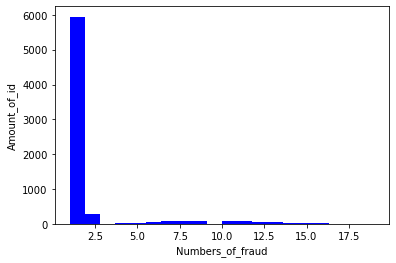

In [16]:
#transactions_fraud = df.loc[df['is_fraud'] == 1]
#transactions_fraud[['sex', 'device_id','browser','source']]
#pd.crosstab(df['device_id'],df['is_fraud'])

max_fraud_id = df.groupby('is_fraud').device_id.value_counts()[1, :]#combien frauds par ID
print(max_fraud_id)

#On les affiche pour mieux voir la distribution
plt.hist(max_fraud_id, color='b', bins=20)
plt.ylabel('Amount_of_id')
plt.xlabel('Numbers_of_fraud');

On se concentre sur les id qui ont fait le plus de transactions fraudeuse > 3:

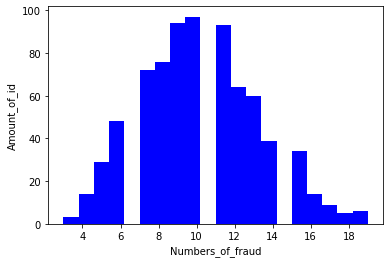

In [17]:
max_fraud_id_more3 = []
for i in max_fraud_id:
    if i >= 3:
        max_fraud_id_more3.append(i)

plt.hist(max_fraud_id_more3, color='b', bins=20)
plt.ylabel('Amount_of_id')
plt.xlabel('Numbers_of_fraud');

In [79]:
pd.crosstab(df['device_id'],df['is_fraud'])

is_fraud,0,1
device_id,,
AAALBGNHHVMKG,1,0
AAAWIHVCQELTP,1,0
AAAXJHWCLISKY,1,0
AAAXXOZJRZRAO,1,10
AABFGRPBQHWFQ,1,0
...,...,...
ZZZGSIJRNCXBJ,1,0
ZZZIKLJSVSQMF,1,0
ZZZKJIZHJEDFN,1,0


<span style="color:green"> **4. Modelisation**</span> 

On peut constater que notre variable cible 'is_fraud' est déséquilibrée, on va utiliser oversampling pour resoudre ce problème. Il y a plusiers methods de suréchantillonnage, l'analyse de nos donées nous dirige vers une méthode SMOTE.

Le SMOTE, acronyme pour Synthetic Minority Oversampling TEchnique, est une méthode de suréchantillonnage des observations minoritaires. Pour éviter de réaliser un simple clonage des minoritaires, le SMOTE se base sur un principe simple : générer de nouveaux minoritaires qui ressemblent aux autres, sans être strictement identiques. Cela permet de densifier de façon plus homogène nos donées minoritaires.

C’est sur ces données transformées, que l’on va ensuite entraîner un modèle de Machine Learning.



Counter({0: 136961, 1: 14151})
Counter({0: 136961, 1: 14151})


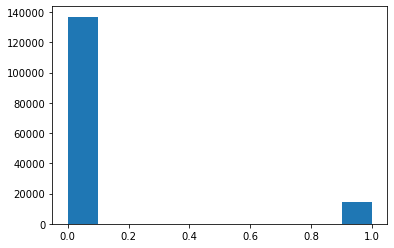

In [35]:
from collections import Counter
from imblearn.over_sampling import SMOTE


#On sépare les variables explicatives de df dans un Dataframe X et la variable cible dans une Series y.
X = df.drop(["is_fraud"], axis = 1)
y = df['is_fraud']


# summarize our class distribution
counter = Counter(y)
print(counter)

# transform the dataset
#oversample = SMOTE()
#X, y = oversample.fit_resample(X, y)

# summarize the new class distribution
counter = Counter(y)
print(counter)

#plot 

plt.hist(y);